# Tarea 2 Eigenfaces

Aprendizaje de Máquina I, 2020

Oscar Esaú Peralta Rosales

Maestría en Ciencias con Especialidad en Computación


In [0]:
from collections import namedtuple

import numpy as np

from matplotlib import pyplot as plt

# Problem 1. PCA implementation


In [0]:
def pca(X:np.array, n_components:int=None, use_SVD=False):
    """ PCA algorithm """
    Result = namedtuple('PCA_R', 'eig_values eig_vectors explained_variance')
    # Data centering
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)
    X[np.isnan(X)] = 0
    
    if not use_SVD:
        # Computation for Correlation Matrix
        X_corr = np.cov(X, rowvar=False)

        # Computation for eigen v
        eig_vals, eig_vecs = np.linalg.eigh(X_corr)
    else:
        _, eig_vals, eig_vecs = np.linalg.svd(X)
        eig_vecs = eig_vecs.T
    
    index_sort = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[index_sort]
    eig_vecs = eig_vecs[:,index_sort]

    # Explained Variance
    explained_variance = np.cumsum(eig_vals) / np.sum(eig_vals)

    # Get the n_components
    n_components = max(1, n_components or eig_vecs.shape[1])
    eig_vecs = eig_vecs[:,:n_components]
    eig_vals = eig_vals[:n_components]

    return Result(eig_vals, eig_vecs, explained_variance[:n_components])


def pca_proyection(X, eig_vecs):
    return np.dot(X, eig_vecs)

In [3]:
x = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

result = pca(x, n_components=2, use_SVD=True)

print("Eigen Values\n", result.eig_values)
print("Eigen Vectors\n", result.eig_vectors)
print("Explained Variance\n", result.explained_variance)
print("Proyection\n", pca_proyection(x, result.eig_vectors))

Eigen Values
 [3.44846097 0.32881144]
Eigen Vectors
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
Explained Variance
 [0.91295003 1.        ]
Proyection
 [[-1.41421356e+00  2.22044605e-16]
 [-2.12132034e+00 -7.07106781e-01]
 [-3.53553391e+00 -7.07106781e-01]
 [ 1.41421356e+00 -2.22044605e-16]
 [ 2.12132034e+00  7.07106781e-01]
 [ 3.53553391e+00  7.07106781e-01]]


# Problem 2. MNIST eigenfaces

Data load

In [4]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step


Transform each image matrix in a sigle row

In [0]:
def image_flatten(X):
    """ Flat each imagen """
    _x = np.zeros((X.shape[0], X.shape[1] * X.shape[2]))
    for i, image in enumerate(X):
        _x[i] = image.flatten()
    return _x

def image_unflatten(X, size=(28, 28)):
    """ Flat each imagen """
    _x = np.zeros((X.shape[0], size[0], size[1]))
    for i, row in enumerate(X):
        _x[i] = row.reshape((size[0], size[1]))
    return _x

In [0]:
X = image_flatten(X_test)

## Variance Explained with PCA components

Making PCA over the data

In [7]:
result = pca(X.copy(), n_components=None, use_SVD=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Plotting the Cumulative Variance Explained

Quantity of Components: 784


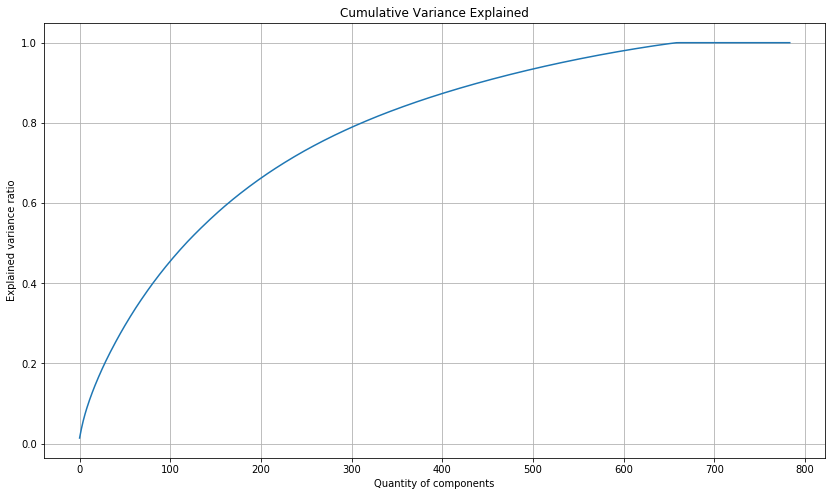

In [8]:
print("Quantity of Components: %s" % (len(result.explained_variance)))
plt.figure(figsize=(14, 8))
plt.plot(result.explained_variance)
plt.title("Cumulative Variance Explained")
plt.xlabel('Quantity of components')
plt.ylabel('Explained variance ratio')
plt.grid(True)
plt.show()

## PCA with different number of components


In [9]:
k_components = [10, 50, 100, 200, 300]

result = pca(X.copy(), n_components=k_components[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
def plot_eigenfaces(eigenfaces:np.array,
                    dim=(1, 1),
                    figsize=(10, 4), 
                    imgdim=(28, 28)):
    """ Plot several eigenfaces in a grid of size dim """
    X = image_unflatten(eigenfaces.copy().T, size=imgdim)
    rows, cols = dim[0], dim[1]
    fig = plt.figure(figsize=figsize)
    fig.subtitle = "Eigenfaces"
    for i in range(cols * rows):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title("Eigenface No. %d" % (i+1))
        plt.imshow(X[i], 'gray')
    plt.show()

### First 10 Eigenfaces

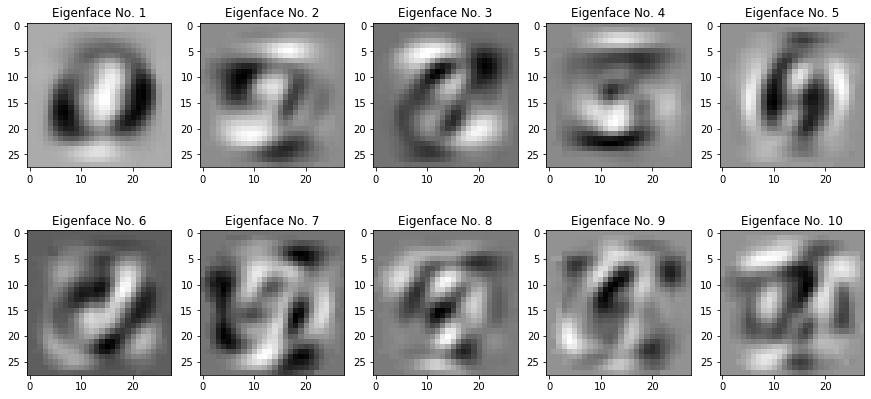

In [11]:
plot_eigenfaces(result.eig_vectors[:,range(0,10)], dim=(2, 5), figsize=(15, 7), imgdim=(28, 28))

### Last 10 eigenfaces with k = 50

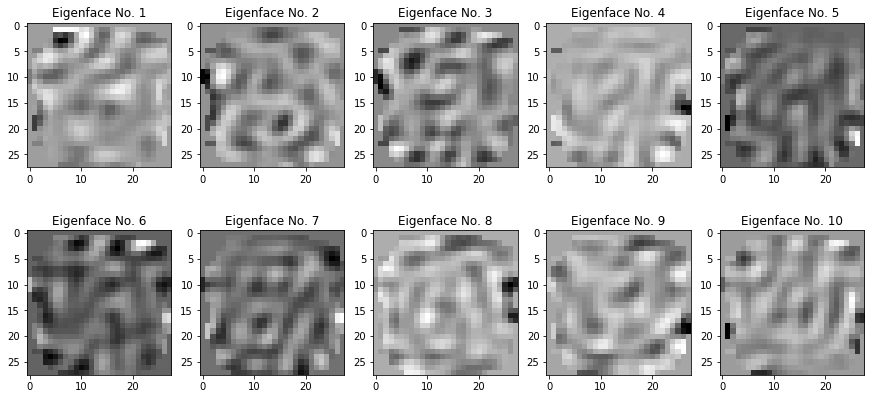

In [12]:
plot_eigenfaces(result.eig_vectors[:,range(40,50)], dim=(2, 5), figsize=(15, 7), imgdim=(28, 28))

### Last 10 Eigenfaces with k = 100

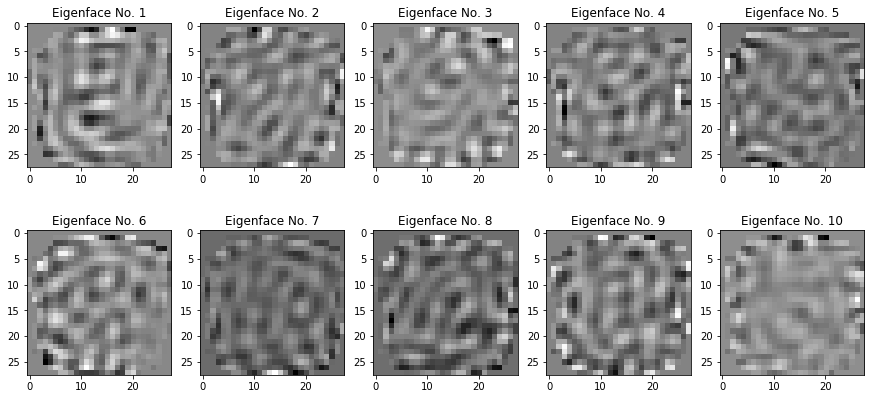

In [13]:
plot_eigenfaces(result.eig_vectors[:,range(90,100)], dim=(2, 5), figsize=(15, 7), imgdim=(28, 28))

### Last 10 Eigenfaces with k = 200

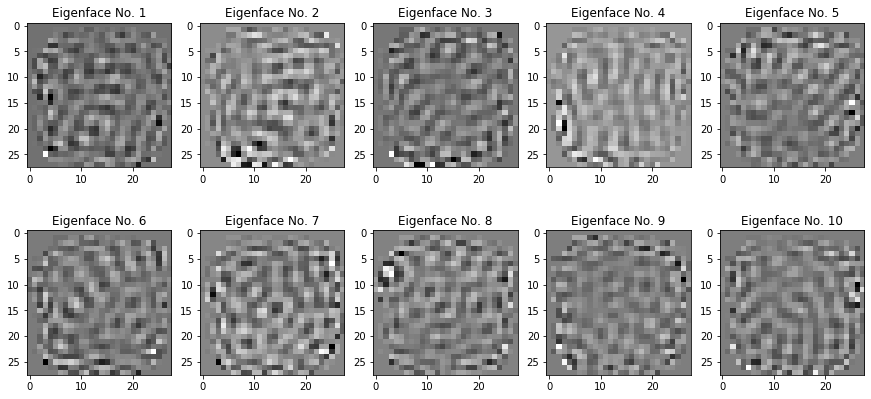

In [14]:
plot_eigenfaces(result.eig_vectors[:,range(190,200)], dim=(2, 5), figsize=(15, 7), imgdim=(28, 28))

### Last 10 Eigenfaces with k = 300

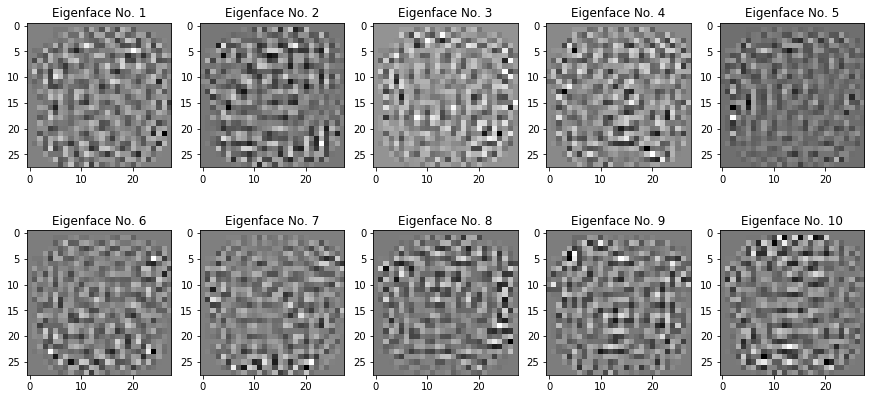

In [15]:
plot_eigenfaces(result.eig_vectors[:,range(290,300)], dim=(2, 5), figsize=(15, 7), imgdim=(28, 28))

## Image reconstruction

Compute the reconstruction for each image and the errors

In [0]:
proyections = [pca_proyection(X, result.eig_vectors[:,range(k)]) for k in k_components]
X_rebuild = [proyections[i] @ result.eig_vectors[:,range(k)].T for i, k in enumerate(k_components)]

### Reconstruction errors


1503.2925100869616
1042.0670144648902
829.2527926806674
568.9991161665016
417.165835966108


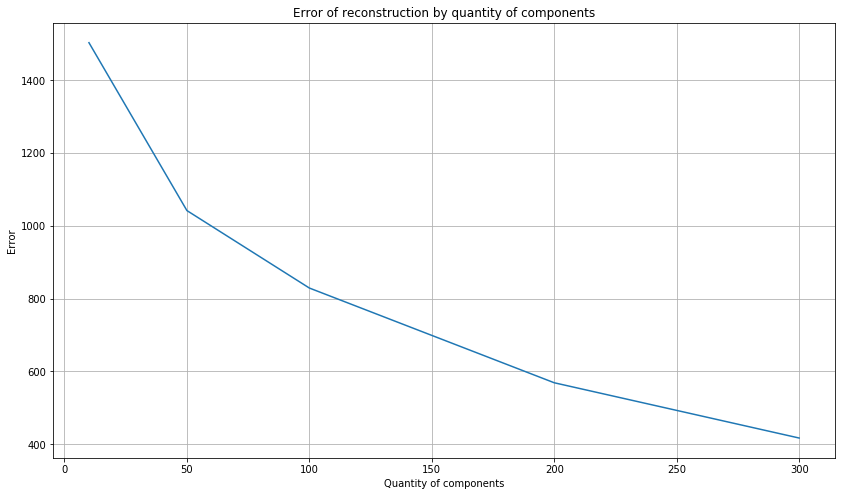

In [17]:
def get_error(X, X_rebuild):
    """ Compute the error for a image reconstruction """
    error = X - X_rebuild
    error = np.linalg.norm(error, axis=1)
    error = np.mean(error)
    print(error)
    return error

errors = [ get_error(X, x_r) for x_r in X_rebuild ]

plt.figure(figsize=(14, 8))
plt.plot(k_components, errors)
plt.title("Error of reconstruction by quantity of components")
plt.xlabel('Quantity of components')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [0]:
def plot_rebuild(X:np.array,
                 X_Rebuild:np.array,
                 dim=(1, 1),
                 figsize=(10, 4), 
                 imgdim=(28, 28)):
    """ Plot several images vs their reconstruction in a grid of size dim """
    X_Rebuild = image_unflatten(X_Rebuild, size=imgdim)
    rows, cols = dim[0], dim[1]
    fig = plt.figure(figsize=figsize)
    fig.subtitle = "Reconstruction of images"
    xr_i = x_i = cont = 0
    for i in range(rows):
        for j in range(cols):
            cont += 1
            ax = fig.add_subplot(rows, cols, cont)
            if i % 2 == 0:
                ax.set_title("Reconstruction No. %d" % (xr_i + 1))
                plt.imshow(X_Rebuild[xr_i], 'gray')
                xr_i += 1
            else:
                ax.set_title("Image No. %d" % (x_i  + 1))
                plt.imshow(X[x_i], 'gray')
                x_i += 1
    plt.show()

### Images reconstruction with k=10

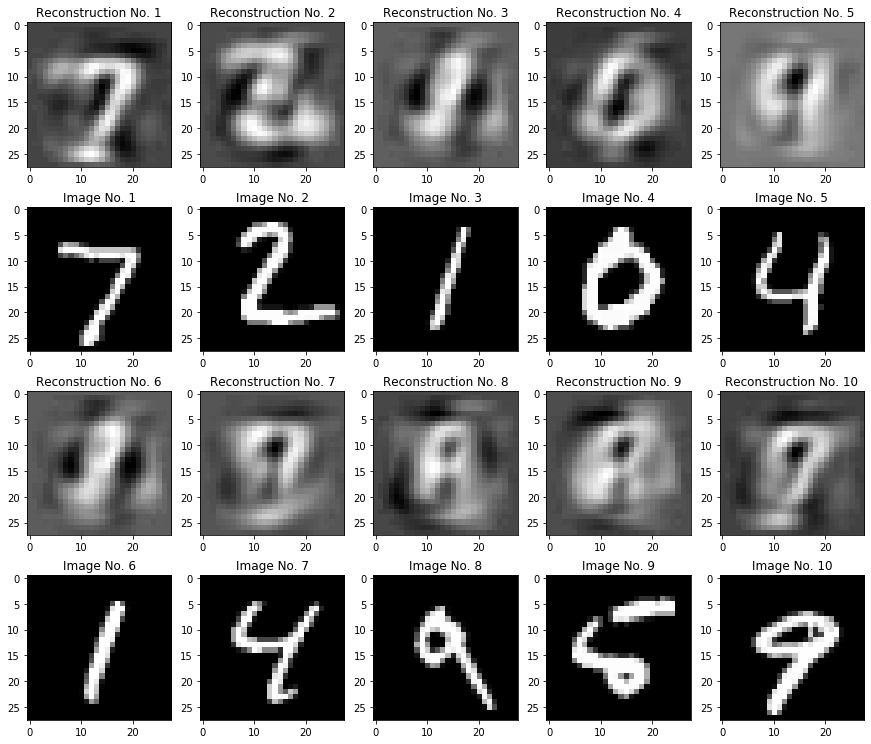

In [19]:
plot_rebuild(X_test, X_rebuild[0], dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

### Images reconstruction with k=50

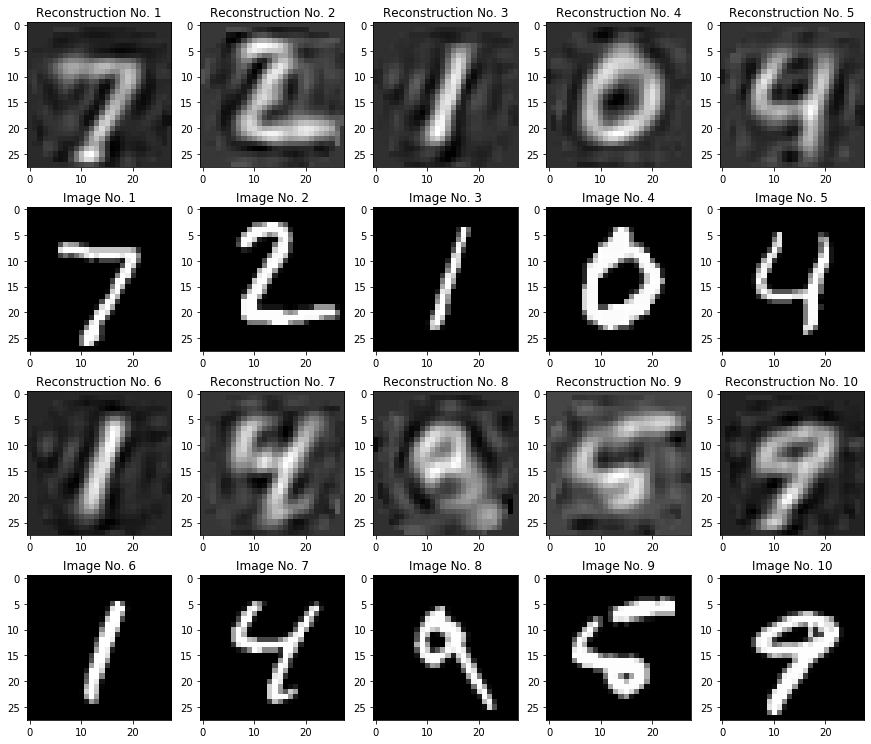

In [20]:
plot_rebuild(X_test, X_rebuild[1], dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

### Images reconstruction with k=100

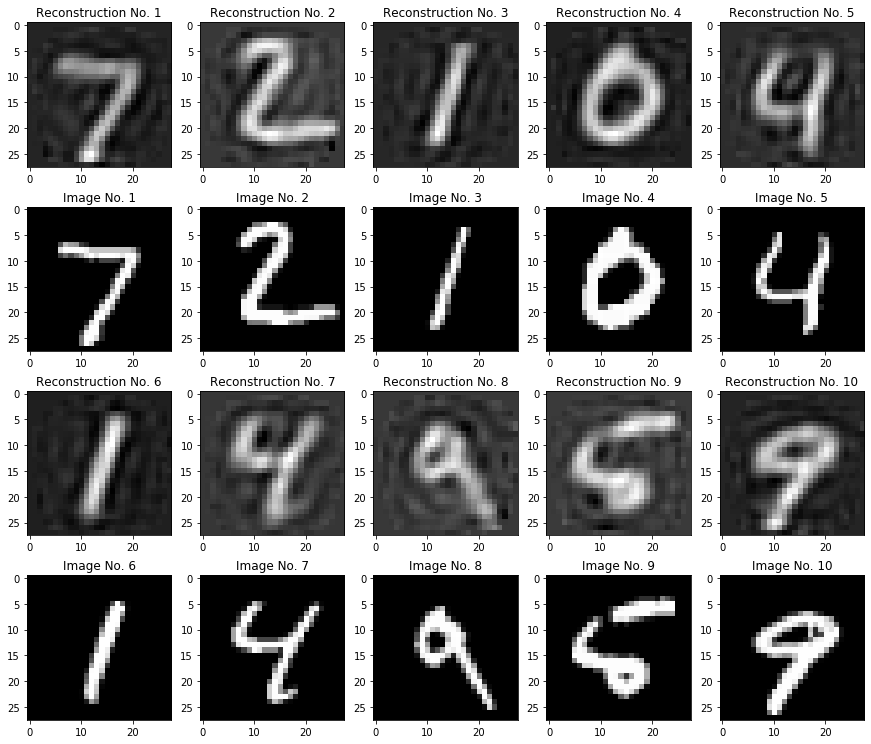

In [21]:
plot_rebuild(X_test, X_rebuild[2], dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

### Images reconstruction with k=200

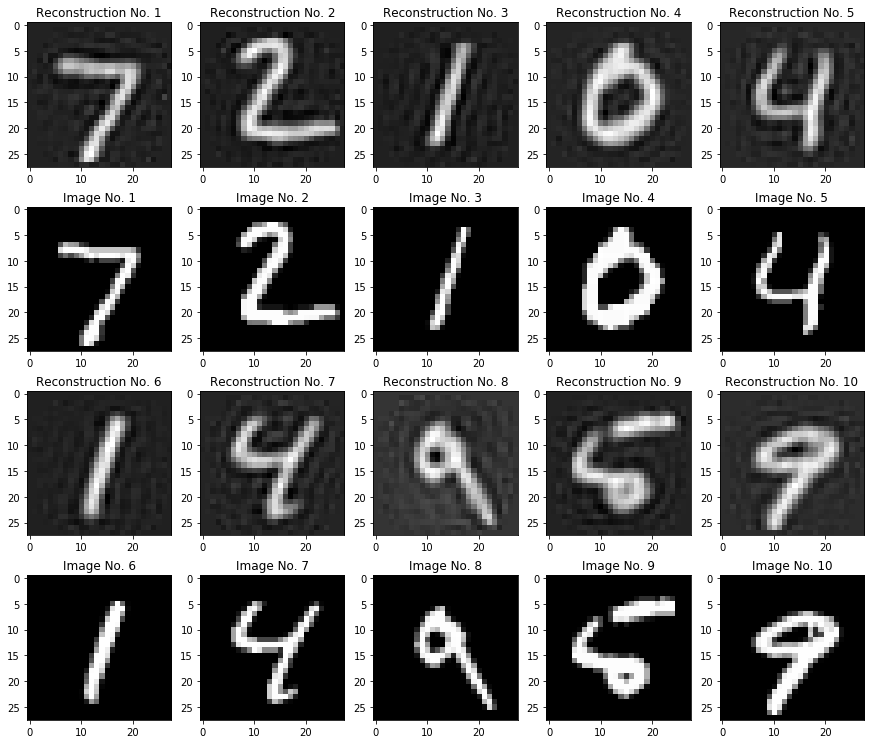

In [22]:
plot_rebuild(X_test, X_rebuild[3], dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

### Images reconstruction with k=300

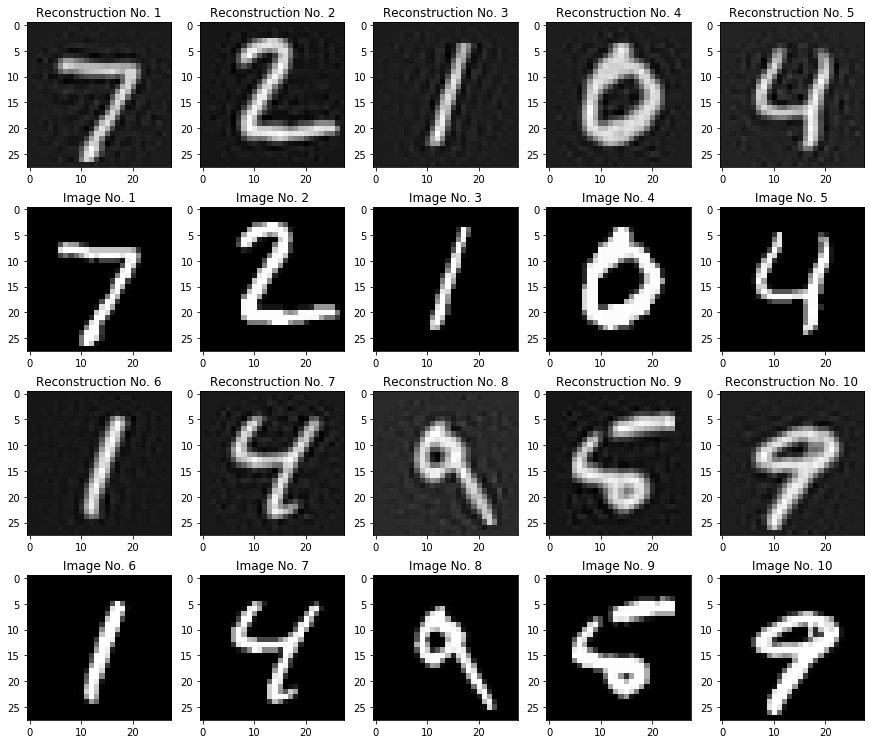

In [23]:
plot_rebuild(X_test, X_rebuild[4], dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

# Problem 3. AT&T Faces

Download the data

In [24]:
from sklearn.datasets import fetch_olivetti_faces

data, targets = fetch_olivetti_faces(return_X_y=True)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [25]:
print(data.shape)
X = data

(400, 4096)


## Variance Explained with PCA components

Quantity of Components: 400


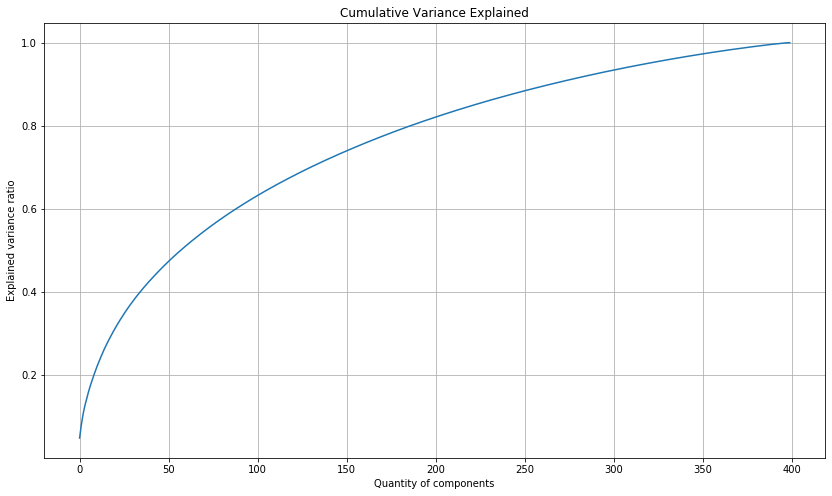

In [26]:
result = pca(X.copy(), n_components=None, use_SVD=True)

print("Quantity of Components: %s" % (len(result.explained_variance)))
plt.figure(figsize=(14, 8))
plt.plot(result.explained_variance)
plt.title("Cumulative Variance Explained")
plt.xlabel('Quantity of components')
plt.ylabel('Explained variance ratio')
plt.grid(True)
plt.show()

## PCA with different number of components

In [0]:
k_components = [10, 50, 100, 200, 300]
result = pca(X.copy(), n_components=k_components[-1])

### Fisrst 10 Eigenfaces

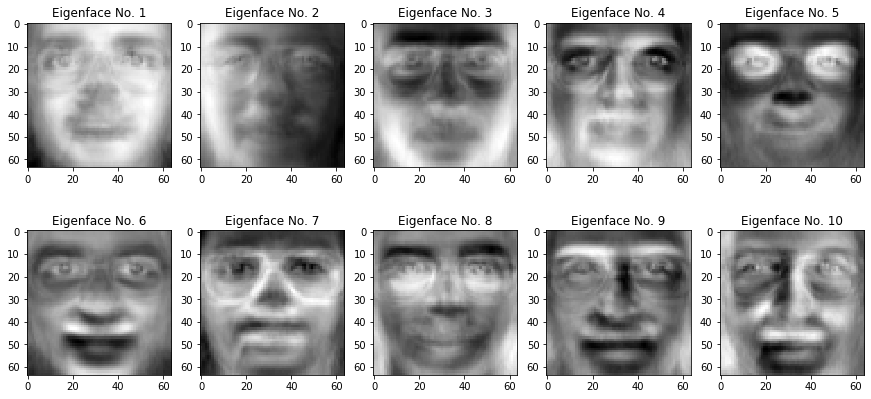

In [28]:
plot_eigenfaces(result.eig_vectors[:,range(0,10)], dim=(2, 5), figsize=(15, 7), imgdim=(64, 64))

### Last 10 Eigenfaces with k = 50

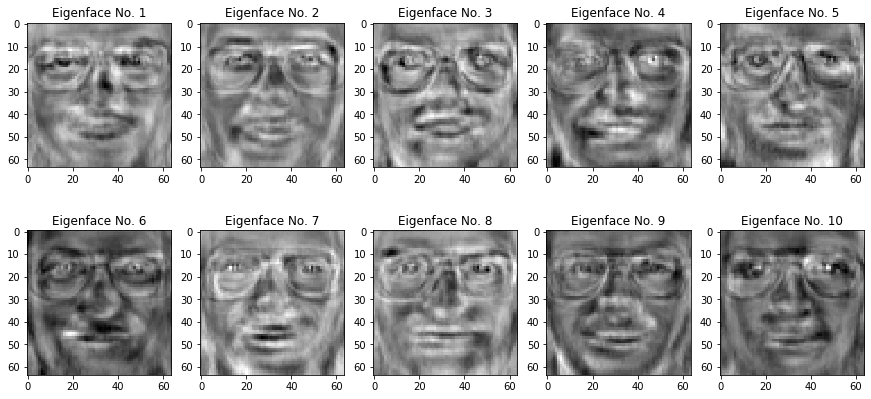

In [29]:
plot_eigenfaces(result.eig_vectors[:,range(40,50)], dim=(2, 5), figsize=(15, 7), imgdim=(64, 64))

### Last 10 Eigenfaces with k = 100

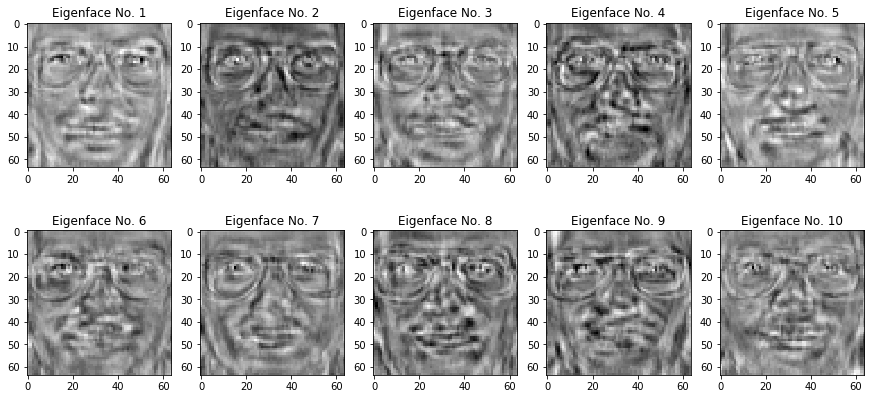

In [30]:
plot_eigenfaces(result.eig_vectors[:,range(90,100)], dim=(2, 5), figsize=(15, 7), imgdim=(64, 64))

### Last 10 Eigenfaces with k = 200

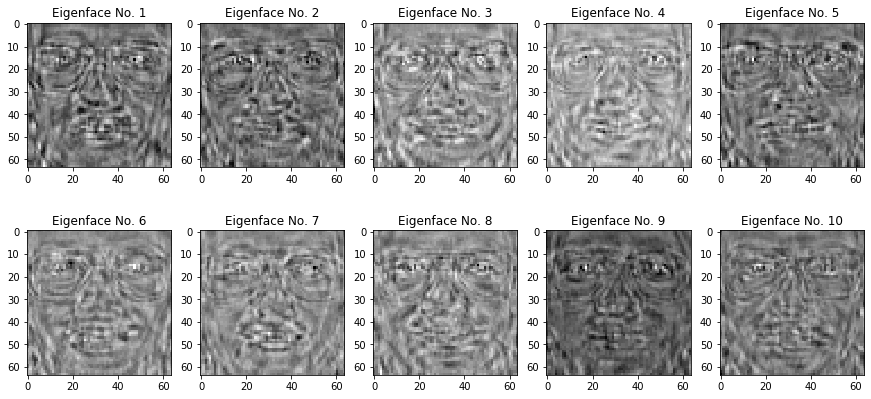

In [31]:
plot_eigenfaces(result.eig_vectors[:,range(190,200)], dim=(2, 5), figsize=(15, 7), imgdim=(64, 64))

### Last 10 Eigenfaces with k = 300

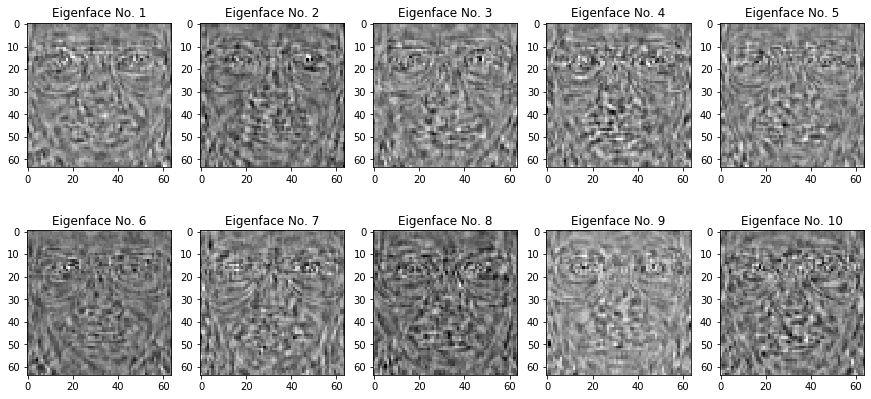

In [32]:
plot_eigenfaces(result.eig_vectors[:,range(290,300)], dim=(2, 5), figsize=(15, 7), imgdim=(64, 64))

## Image reconstruction

Compute the reconstruction for each image and the errors

In [0]:
proyections = [pca_proyection(X, result.eig_vectors[:,range(k)]) for k in k_components]
X_rebuild = [proyections[i] @ result.eig_vectors[:,range(k)].T for i, k in enumerate(k_components)]

### Reconstruction errors

7.739901458682722
4.898483551287283
3.8509103633374924
2.9810208576551167
2.5198023383784593


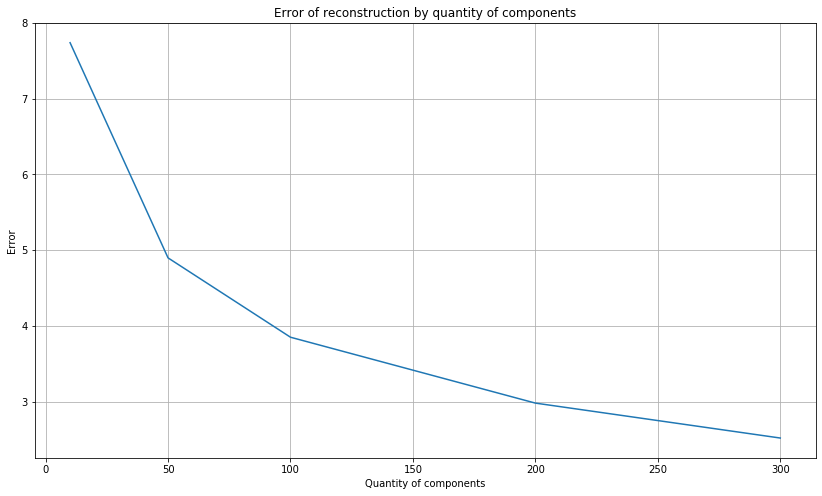

In [34]:
errors = [ get_error(X, x_r) for x_r in X_rebuild ]

plt.figure(figsize=(14, 8))
plt.plot(k_components, errors)
plt.title("Error of reconstruction by quantity of components")
plt.xlabel('Quantity of components')
plt.ylabel('Error')
plt.grid(True)
plt.show()

### Images reconstruction with k=10

In [0]:
X_unflatten = image_unflatten(X, size=(64, 64))

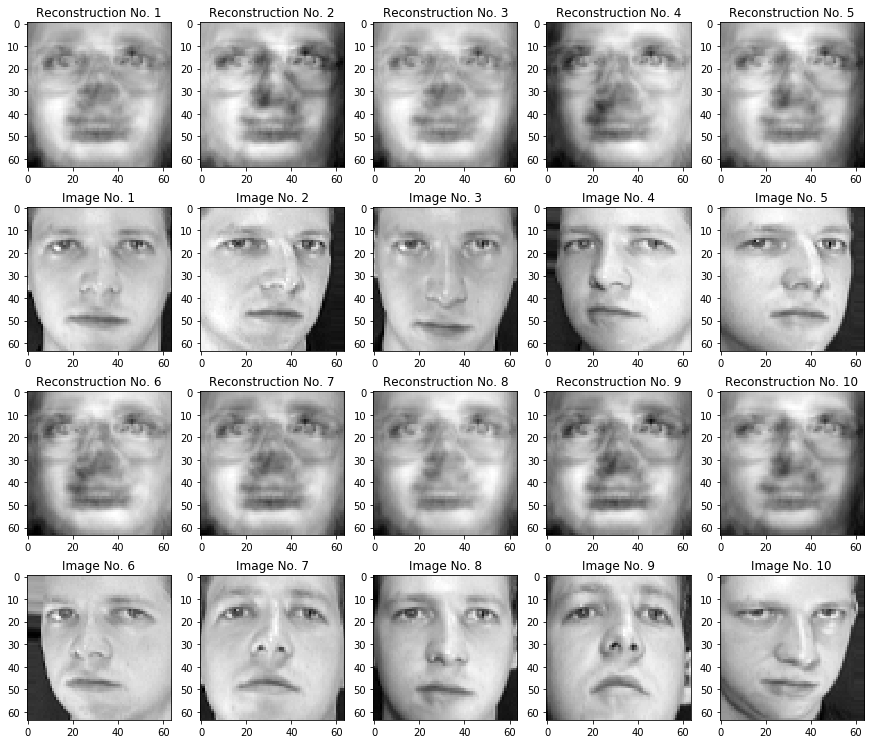

In [36]:
plot_rebuild(X_unflatten, X_rebuild[0], dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

### Images reconstruction with k=50

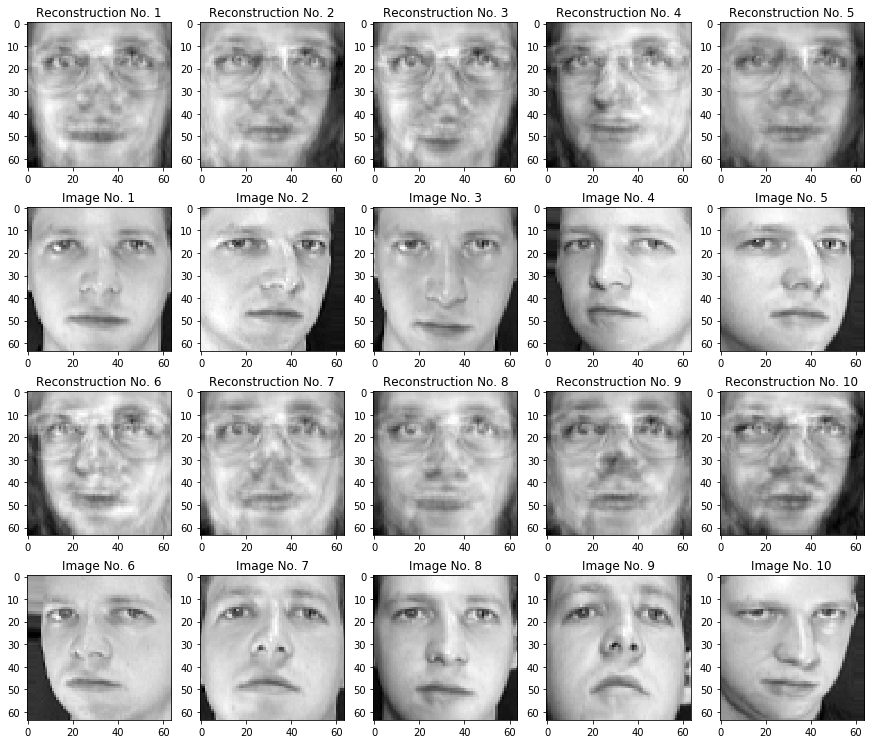

In [37]:
plot_rebuild(X_unflatten, X_rebuild[1], dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

### Images reconstruction with k=100

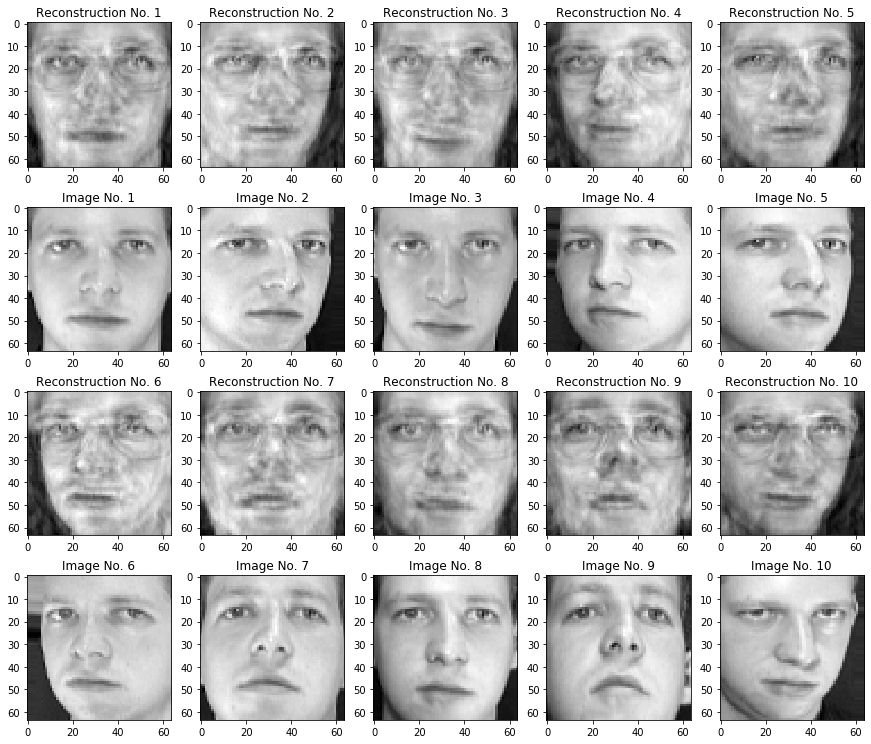

In [38]:
plot_rebuild(X_unflatten, X_rebuild[2], dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

### Images reconstruction with k=200

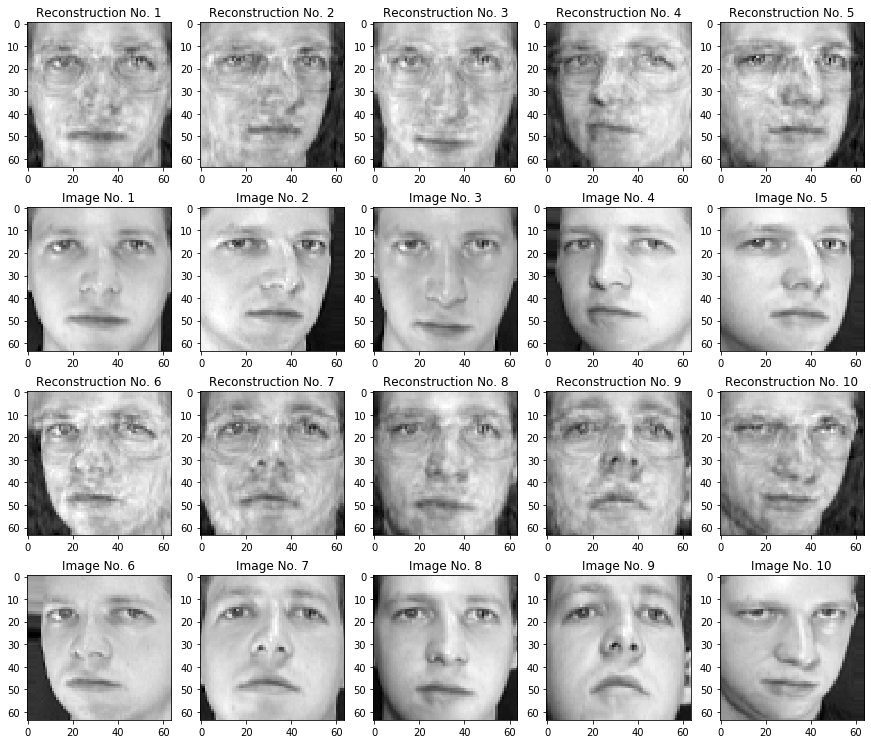

In [39]:
plot_rebuild(X_unflatten, X_rebuild[3], dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

### Images reconstruction with k=300

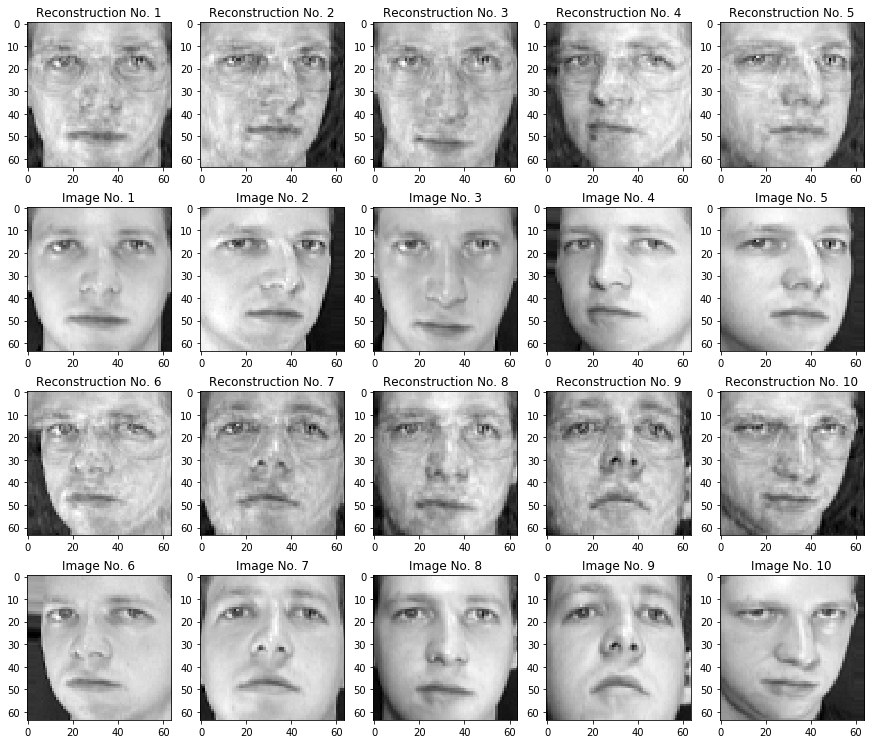

In [40]:
plot_rebuild(X_unflatten, X_rebuild[4], dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

# PCA comparisons

## From sklearn

In [0]:
from sklearn.decomposition import PCA

1554.7424601302948
Error: 1554.7424601302948


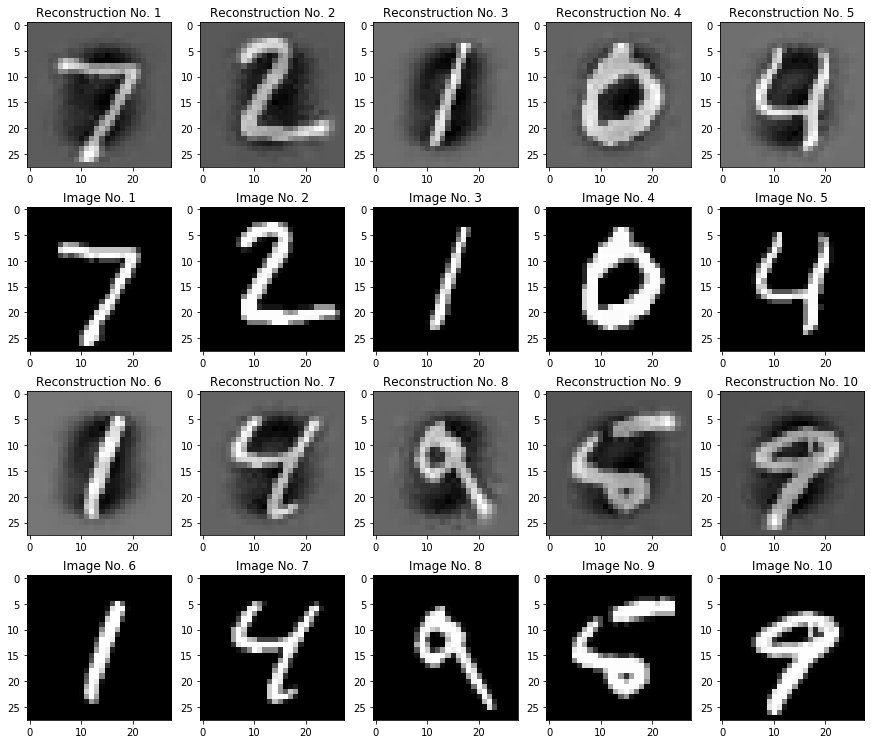

In [42]:
_X = X_test
_X = image_flatten(_X)
_pca = PCA(n_components=300)
X_new = _pca.fit_transform(_X)
X_rebuild = X_new @ _pca.components_
print('Error:', get_error(_X, X_rebuild))
plot_rebuild(X_test, X_rebuild, dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

35.625458
Error: 35.625458


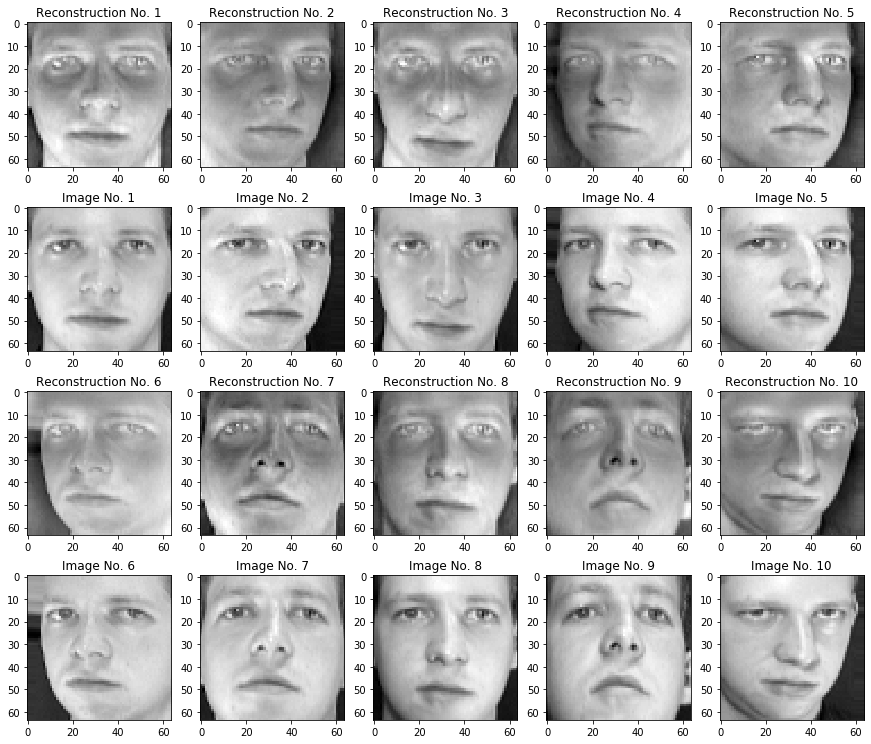

In [43]:
_X = data
_pca = PCA(n_components=300)
X_new = _pca.fit_transform(_X)
X_rebuild = X_new @ _pca.components_
print('Error:', get_error(_X, X_rebuild))
plot_rebuild(image_unflatten(_X, size=(64, 64)), X_rebuild, dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

## Own PCA using SVD Decomposition

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


417.1658359661082
Error: 417.1658359661082


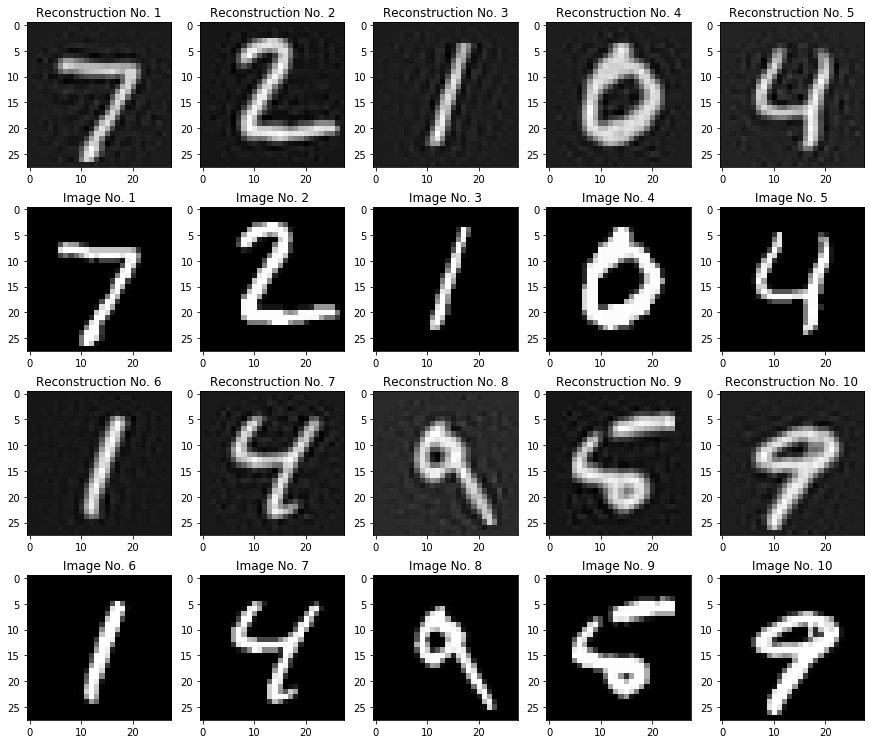

In [44]:
_X = X_test
_X = image_flatten(_X)
_pca = pca(_X, n_components=300, use_SVD=True)
proyections = pca_proyection(_X, _pca.eig_vectors)
X_rebuild =  proyections @ _pca.eig_vectors.T
print('Error:', get_error(_X, X_rebuild))
plot_rebuild(X_test, X_rebuild, dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

2.5198023
Error: 2.5198023


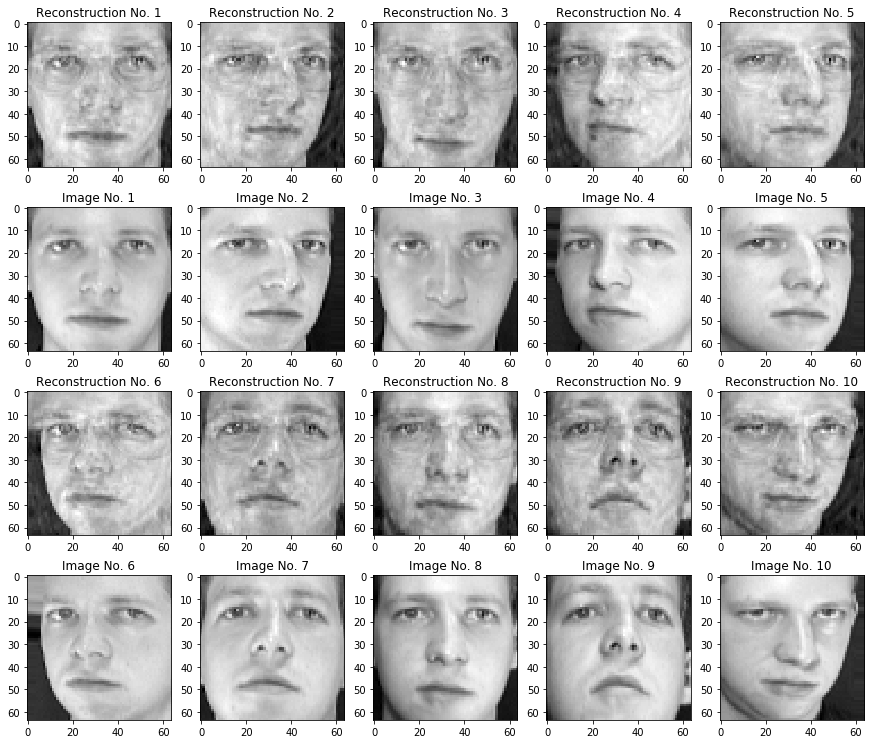

In [45]:
_X = data
# _X = image_flatten(_X)
_pca = pca(_X, n_components=300, use_SVD=True)
proyections = pca_proyection(_X, _pca.eig_vectors)
X_rebuild =  proyections @ _pca.eig_vectors.T
print('Error:', get_error(_X, X_rebuild))
plot_rebuild(image_unflatten(_X, size=(64, 64)) , X_rebuild, dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))

## Own PCA using Correlation Matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


417.165835966108
Error: 417.165835966108


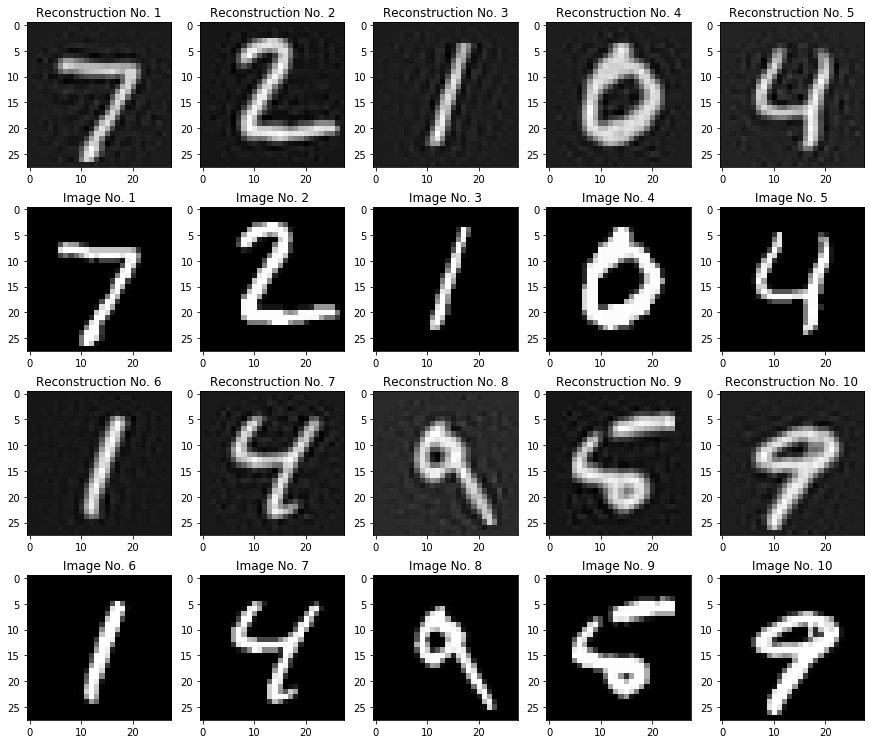

In [46]:
_X = X_test
_X = image_flatten(_X)
_pca = pca(_X, n_components=300, use_SVD=False)
proyections = pca_proyection(_X, _pca.eig_vectors)
X_rebuild =  proyections @ _pca.eig_vectors.T
print('Error:', get_error(_X, X_rebuild))
plot_rebuild(X_test, X_rebuild, dim=(4, 5), figsize=(15, 13), imgdim=(28, 28))

2.5198023
Error: 2.5198023


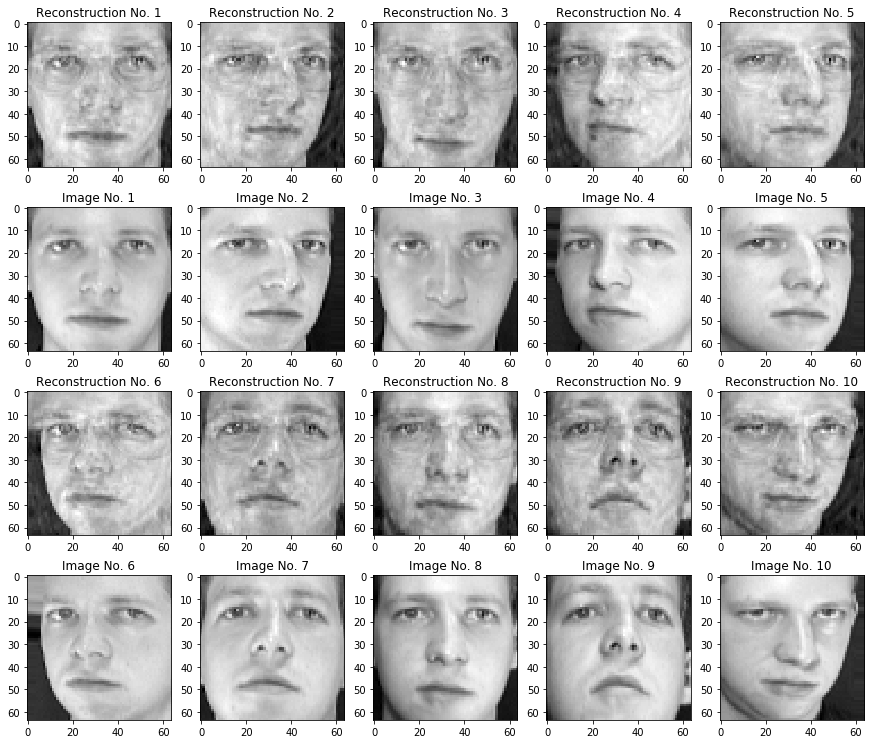

In [47]:
_X = data
# _X = image_flatten(_X)
_pca = pca(_X, n_components=300, use_SVD=True)
proyections = pca_proyection(_X, _pca.eig_vectors)
X_rebuild =  proyections @ _pca.eig_vectors.T
print('Error:', get_error(_X, X_rebuild))
plot_rebuild(image_unflatten(_X, size=(64, 64)) , X_rebuild, dim=(4, 5), figsize=(15, 13), imgdim=(64, 64))


## Execution Comparison

In [48]:
import time

_X = X_test
_X = image_flatten(_X)

_iter = 5

time1 = []
time2 = []
time3 = []

for _ in range(_iter):
    start = time.time()
    pca(_X, n_components=None, use_SVD=True)
    end = time.time()
    time1.append(end - start)

for _ in range(_iter):
    start = time.time()
    pca(_X, n_components=None, use_SVD=False)
    end = time.time()
    time2.append(end - start)

for _ in range(_iter):
    start = time.time()
    _pca = PCA(n_components=300)
    end = time.time()
    time3.append(end - start)


print('Time rate SVD/CORR: ', np.mean(time1) / np.mean(time2))
print('Time rate SVD/sklearn: ', np.mean(time1) / np.mean(time3))
print('Time rate Correlation/sklearn: ', np.mean(time2) / np.mean(time3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Time rate SVD/CORR:  36.382990446152974
Time rate SVD/sklearn:  295495.2905027933
Time rate Correlation/sklearn:  8121.797765363129


## Resultados

Para la implementación del método de PCA se realizó mediante dos aproximaciones, la primera a través de la matriz de correlacion y la segunda usando una descomposición SVD.

Como se observa en los tiempos, la implementación usando la matriz de correlación es alrededor de 30 veces más rápida que usando una descomposición SVD y al rededor de un 30 porciento más rápido que la de sklearn; cabe recalcar que al momento desconozco la implementación usada en sklearn, la implementada aquí es muy básica.

Apesar de los tiempos los 3 métodos, estos mostraron resultados similares, el usado por sklearn al reconstruir se obtiene imágenes mas nítidas pero como se puede observar en los caso de los números, el color de fondo no coincide del todo.

Los primeros eigenfaces guardan bastante información con respecto a las caracterisitcas físicas de la cara como ojos, boca (expresiones, de sonrisa, enojo, trizteza, etc.), barba, orejas, accesorios como lentes que como se espera son atributos que no cambian demasiado en todas las personas. Mientras gráficamos más eigenfaces la noción de la información que guardan no es tan evidente.

Para el dataset de MNIST con un k=100 ya se obtienen buenos resultados para caracterización de los números, el error obtenido no es bastante alto. Error es calculado promediando la norma de las diferencias entre las imagenes de las dos matrices, la reconstruida y la original. Para este dataset se observa que se obtiene mejor el color de fondo respecto a los resultados de sklearn

Para el dataset de AT&T las reconstrucciones son mucho mejores a partir de k=300. En este dataset y por ellos se obtuvieron errores de reconstrucción bastante bajos.

